### In The Name Of God


# Investigating Transfer Learning Capabilities of Vision Transformers and CNNs by Fine-Tuning a Single Trainable Block
----------------

#### MohammadMahdi Barghi

#### June 2024



# Initialize

## Install and Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import os
import time
import math
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as plt
import matplotlib.pyplot as plt

# /////////////////////////////////////////////////////////////////
import torch
import timm
import torchvision
import torchvision.transforms as transforms
from timm.models.vision_transformer import VisionTransformer
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:{device}")

device:cuda:0


## load dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43277979.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## check loaded dataset

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


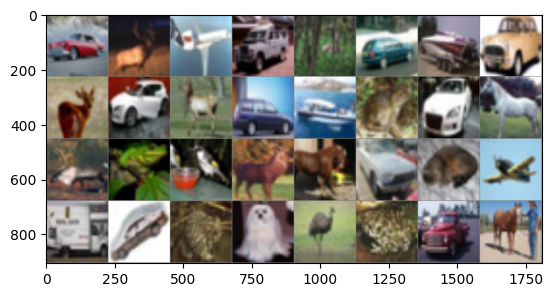

car   deer  plane car   deer  car   ship  car   deer  car   deer  car   ship  frog  car   horse deer  frog  bird  deer  horse car   cat   plane truck car   frog  dog   bird  frog  car   horse


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# densenet201 Model (CNN)

In [ ]:
model = models.densenet201(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 112MB/s]


## freeze and unfreeze layers

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if "denseblock4.denselayer16" in name:
        param.requires_grad = True


In [ ]:
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(classes))

In [ ]:
print(f'num_features: {num_features}')
print(f'model.classifier: {model.classifier}')

num_features: 1920
model.classifier: Linear(in_features=1920, out_features=10, bias=True)


## trainable parameters


In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

Number of trainable parameters: 235210


## fine-tune



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

### train function

In [ ]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_accuracy = 100. * correct / total

    return epoch_loss, epoch_accuracy


### validation function

In [ ]:
def validate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(testloader.dataset)
    epoch_accuracy = 100. * correct / total

    return epoch_loss, epoch_accuracy


### traning loop

In [ ]:
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
num_epochs = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_times, val_times = [], []

In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
    end_time = time.time()
    train_times.append(end_time - start_time)

    start_time = time.time()
    val_loss, val_accuracy = validate(model, testloader, criterion, device)
    end_time = time.time()
    val_times.append(end_time - start_time)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f"\n\n\n-------------------------------   Epoch {epoch+1}/{num_epochs}    ------------------------------")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n "
          f"Train Time: {train_times[-1]:.2f}s, Validation Time: {val_times[-1]:.2f}s\n")




-------------------------------   Epoch 1/10    ------------------------------
Train Loss: 0.9497, Train Accuracy: 76.65%
 Validation Loss: 0.4877, Validation Accuracy: 87.06%
 Train Time: 294.05s, Validation Time: 53.23s




-------------------------------   Epoch 2/10    ------------------------------
Train Loss: 0.4435, Train Accuracy: 87.52%
 Validation Loss: 0.3472, Validation Accuracy: 89.50%
 Train Time: 299.63s, Validation Time: 52.47s




-------------------------------   Epoch 3/10    ------------------------------
Train Loss: 0.3323, Train Accuracy: 90.38%
 Validation Loss: 0.3048, Validation Accuracy: 90.37%
 Train Time: 300.31s, Validation Time: 53.05s




-------------------------------   Epoch 4/10    ------------------------------
Train Loss: 0.2661, Train Accuracy: 92.29%
 Validation Loss: 0.2733, Validation Accuracy: 91.28%
 Train Time: 300.30s, Validation Time: 53.34s




-------------------------------   Epoch 5/10    ------------------------------
Train Loss: 0.

### save model

In [ ]:
model_save_path = '/content/drive/MyDrive/Deep_learning/HW5/fine_tuned_densenet201_10.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}, model_save_path)

print(f'Model saved!!')


Model saved!!


## Visualize the training and validation


### loss

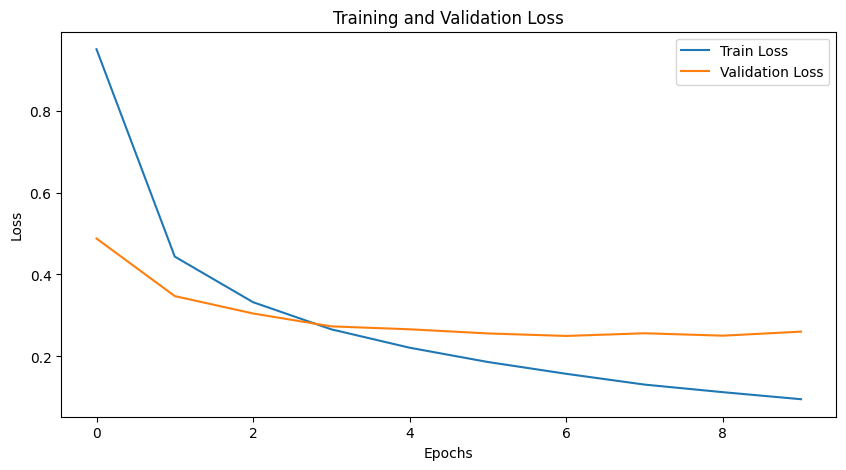

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### accuracy

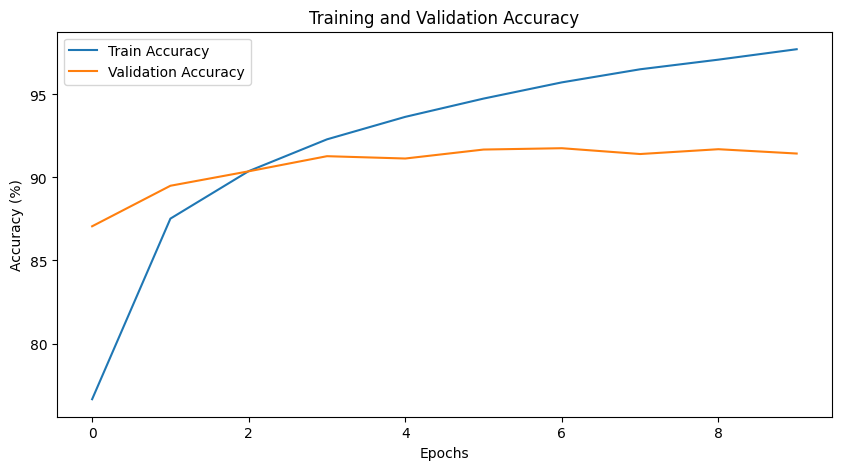

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## calculate training and validation time

In [ ]:
total_train_time = sum(train_times)
total_val_time = sum(val_times)
average_train_time = total_train_time / num_epochs
average_val_time = total_val_time / num_epochs

print(f"Average training time per epoch: {average_train_time:.2f}s")
print(f"Average validation time per epoch: {average_val_time:.2f}s")


Average training time per epoch: 299.59s
Average validation time per epoch: 53.12s


# DeiTBaseDistilled Model (Transformer)

In [ ]:
class CustomDeiT(nn.Module):
    def __init__(self, num_classes):
        super(CustomDeiT, self).__init__()
        self.model = timm.create_model('deit_base_distilled_patch16_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
        self.model.head_dist = nn.Linear(self.model.head_dist.in_features, num_classes)

    def forward(self, x):
        x = self.model.forward_features(x)
        cls_token = self.model.head(x[:, 0])
        dist_token = self.model.head_dist(x[:, 1])
        return cls_token, dist_token

In [ ]:
num_classes = len(classes)
model = CustomDeiT(num_classes)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

## freeze and unfreeze layers

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if "blocks.11" in name:
        param.requires_grad = True

In [ ]:
model.model.head = nn.Linear(model.model.head.in_features, num_classes)
model.model.head_dist = nn.Linear(model.model.head_dist.in_features, num_classes)

## trainable parameters

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

Number of trainable parameters: 7103252


## fine-tune



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

### train function

In [ ]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        cls_token, dist_token = model(inputs)
        loss = criterion(cls_token, labels) + criterion(dist_token, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = cls_token.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy

### validation function

In [ ]:
def validate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            cls_token, dist_token = model(inputs)
            loss = criterion(cls_token, labels) + criterion(dist_token, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = cls_token.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(testloader.dataset)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy

### training loop

In [ ]:
model.to(device)

CustomDeiT(
  (model): VisionTransformerDistilled(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=

In [ ]:
num_epochs = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_times, val_times = [], []

In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
    end_time = time.time()
    train_times.append(end_time - start_time)

    start_time = time.time()
    val_loss, val_accuracy = validate(model, testloader, criterion, device)
    end_time = time.time()
    val_times.append(end_time - start_time)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f"\n\n\n-------------------------------   Epoch {epoch+1}/{num_epochs}    ------------------------------")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n "
          f"Train Time: {train_times[-1]:.2f}s, Validation Time: {val_times[-1]:.2f}s\n")




-------------------------------   Epoch 1/10    ------------------------------
Train Loss: 0.3769, Train Accuracy: 93.92%
 Validation Loss: 0.2242, Validation Accuracy: 96.26%
 Train Time: 627.09s, Validation Time: 108.95s




-------------------------------   Epoch 2/10    ------------------------------
Train Loss: 0.1320, Train Accuracy: 97.87%
 Validation Loss: 0.2144, Validation Accuracy: 96.60%
 Train Time: 626.31s, Validation Time: 108.55s




-------------------------------   Epoch 3/10    ------------------------------
Train Loss: 0.0512, Train Accuracy: 99.25%
 Validation Loss: 0.2587, Validation Accuracy: 96.09%
 Train Time: 625.69s, Validation Time: 108.44s




-------------------------------   Epoch 4/10    ------------------------------
Train Loss: 0.0194, Train Accuracy: 99.73%
 Validation Loss: 0.2680, Validation Accuracy: 96.59%
 Train Time: 625.90s, Validation Time: 108.58s




-------------------------------   Epoch 5/10    ------------------------------
Train Loss

### save model

In [ ]:
model_save_path = '/content/drive/MyDrive/Deep_learning/HW5/fine_tuned_deit_base_distilled_10.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}, model_save_path)

print(f'Model saved!!')

Model saved!!


## Visualize the training and validation


### loss

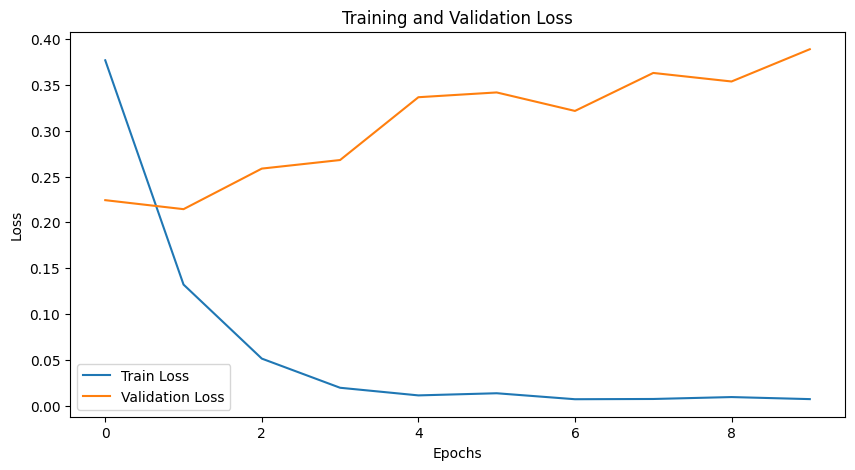

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### accuracy

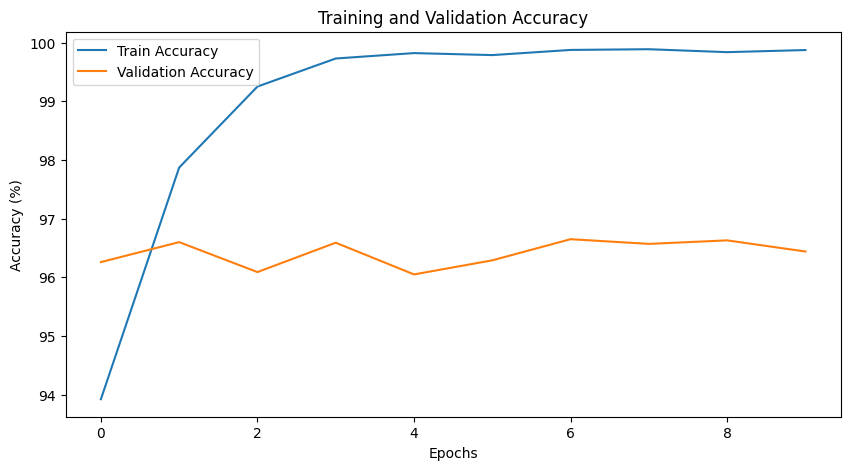

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## calculate training and validation time

In [ ]:
total_train_time = sum(train_times)
total_val_time = sum(val_times)
average_train_time = total_train_time / num_epochs
average_val_time = total_val_time / num_epochs

print(f"Average training time per epoch: {average_train_time:.2f}s")
print(f"Average validation time per epoch: {average_val_time:.2f}s")

Average training time per epoch: 626.44s
Average validation time per epoch: 108.66s


# CaiTS24 (transformer)

In [ ]:
model = timm.create_model('cait_s24_224', pretrained=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

## freeze and unfreeze layers

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if "blocks.23" in name:
        param.requires_grad = True

## trainable parameters

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {trainable_params}')

Number of trainable parameters: 1775376


## fine-tune

In [ ]:
num_classes = len(classes)
model.head = nn.Linear(model.head.in_features, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

### train function

In [ ]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy

### validation function

In [ ]:
def validate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    epoch_loss = running_loss / len(testloader.dataset)
    epoch_accuracy = 100. * correct / total
    return epoch_loss, epoch_accuracy


### training loop

In [ ]:
model.to(device)

Cait(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): LayerScaleBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): TalkingHeadAttn(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_l): Linear(in_features=8, out_features=8, bias=True)
        (proj_w): Linear(in_features=8, out_features=8, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [ ]:
num_epochs = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
train_times, val_times = [], []

In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
    end_time = time.time()
    train_times.append(end_time - start_time)

    start_time = time.time()
    val_loss, val_accuracy = validate(model, testloader, criterion, device)
    end_time = time.time()
    val_times.append(end_time - start_time)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f"\n\n\n-------------------------------   Epoch {epoch+1}/{num_epochs}    ------------------------------")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n "
          f"Train Time: {train_times[-1]:.2f}s, Validation Time: {val_times[-1]:.2f}s\n")




-------------------------------   Epoch 1/10    ------------------------------
Train Loss: 0.2077, Train Accuracy: 93.27%
 Validation Loss: 0.1199, Validation Accuracy: 95.92%
 Train Time: 587.99s, Validation Time: 109.22s




-------------------------------   Epoch 2/10    ------------------------------
Train Loss: 0.0734, Train Accuracy: 97.65%
 Validation Loss: 0.1157, Validation Accuracy: 96.11%
 Train Time: 590.77s, Validation Time: 109.19s




-------------------------------   Epoch 3/10    ------------------------------
Train Loss: 0.0327, Train Accuracy: 99.06%
 Validation Loss: 0.1044, Validation Accuracy: 96.80%
 Train Time: 591.61s, Validation Time: 108.80s




-------------------------------   Epoch 4/10    ------------------------------
Train Loss: 0.0136, Train Accuracy: 99.65%
 Validation Loss: 0.1221, Validation Accuracy: 96.39%
 Train Time: 590.30s, Validation Time: 109.18s




-------------------------------   Epoch 5/10    ------------------------------
Train Loss

### save model

In [ ]:
model_save_path = '/content/drive/MyDrive/Deep_learning/HW5/cait_s24_10.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}, model_save_path)

print(f'Model saved!!')

Model saved!!


## Visualize the training and validation


### loss

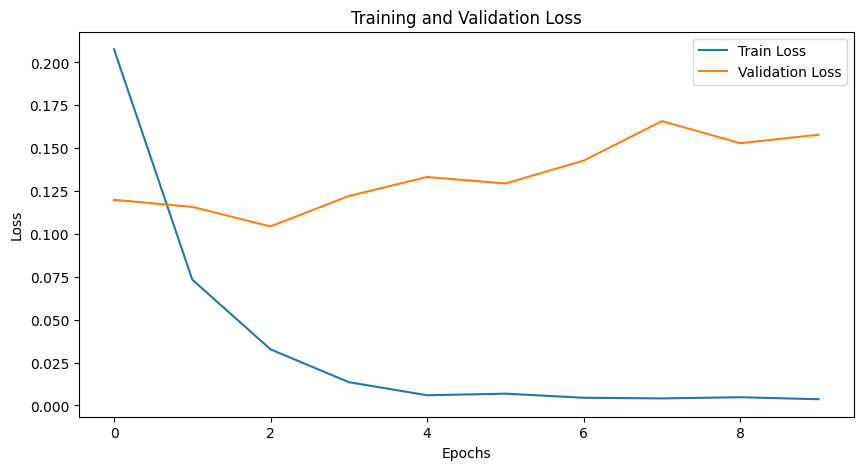

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### accuracy

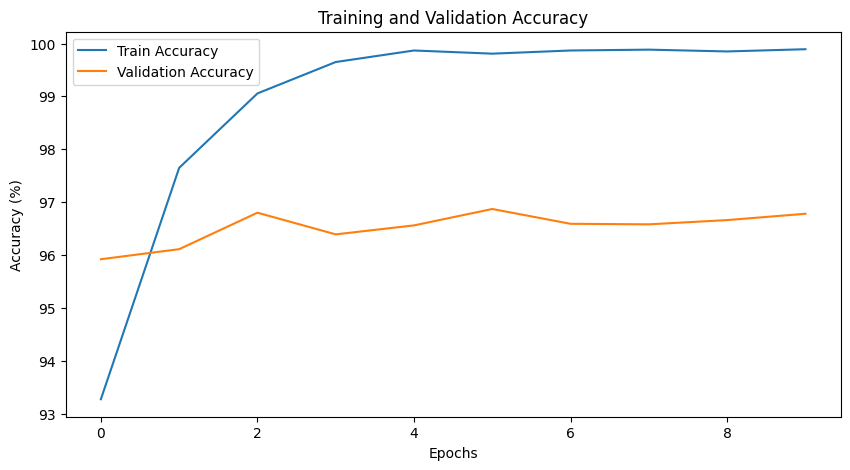

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## calculate training and validation time

In [ ]:
total_train_time = sum(train_times)
total_val_time = sum(val_times)
average_train_time = total_train_time / num_epochs
average_val_time = total_val_time / num_epochs

print(f"Average training time per epoch: {average_train_time:.2f}s")
print(f"Average validation time per epoch: {average_val_time:.2f}s")

Average training time per epoch: 590.62s
Average validation time per epoch: 109.12s
